# 언어 모델
# (4차 미분방정식, 편미분으로 설명하는 것이 좋다)
# - 주어진 텍스트 시퀸스("hello, i am bgy.")에서 다음에 올 "토큰"을 예측(즉 확률)하는 모델
# - 자기회귀적: 이전에 생성된 토큰들을 바탕으로 다음 토큰을 "순차적"으로 생성
# 캐주얼 마스크: 미래 토큰을 참조하지 못하도록 하는 방법

## 트랜스포머 핵심 구성 요소
1. 토큰 임베딩 + 위치 임베딩 ********

2. 멀티헤드 어텐션
3. 피드포워드 네트워크
4. 레이어 정규화
5. 잔차 연결(기울기 소실을 막아줌)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [2]:
class SimpleTokenizer:
    """
    핵심 기능
    1) 어휘 사전을 적성(token)
    2) 텍스트 숫자의 시퀸스
    3) 숫자 인덱스를 텍스트로 변환
    """
    def __init__(self): # 매개변수 없는 생성자
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0

    def build_vocab(self, text):
        chars = sorted(list(set(text))) 
        self.vocab_size = len(chars)
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)} # dictionary comprehensive # 여기서 키를 unique하게 만들어줘야 하기 때문에 위에서 set해줌
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}

    def encode(self, text):
        """텍스트를 토큰 인덱스로 변환"""
        return [self.char_to_idx.get(ch, 0) for ch in text] # 딕셔너리.get(ch, 0) 있으면 ch의 값 가져오고 없으면 defalt 0 가져와라 

    def decode(self, indices):
        """인덱스를 텍스트로 변환"""
        return "".join([self.idx_to_char.get(i, "") for i in indices])

In [3]:
class MultiHeadAttention(nn.Module):
    """멀티헤드 어텐션 메커니즘"""

    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model # hidden size 입력 벡터의 차원
        self.n_heads = n_heads # 논문에선 8개
        self.d_k = d_model // n_heads # 각 헤더에서 사용할 차원수

        # query key value output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        # Q, K, V 계산
        Q = (
            self.W_q(x)
            .view(batch_size, seq_len, self.n_heads, self.d_k)
            .transpose(1, 2)
        )
        K = (
            self.W_k(x)
            .view(batch_size, seq_len, self.n_heads, self.d_k)
            .transpose(1, 2)
        )
        V = (
            self.W_v(x)
            .view(batch_size, seq_len, self.n_heads, self.d_k)
            .transpose(1, 2)
        )

        # 어텐션 점수 계산
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        # 마스킹 (causal attention)
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)

        # 소프트맥스 적용
        attention_weights = F.softmax(scores, dim=-1)

        # Value와 곱하기
        context = torch.matmul(attention_weights, V)
        context = (
            context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        )

        return self.W_o(context)

In [4]:
class TransformerBlock(nn.Module):
	"""
	1. 멀티헤드 어텐션(*)
	2. 잔차 연결(기울기 소실을 막아줌)
	3. 레이어 정규화
	4. 피드포워드 네트워크
	5. 잔차 연결(기울기 소실을 막아줌)
	"""

	def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
		super().__init__()
		self.attention = MultiHeadAttention(d_model, n_heads)
		self.norm1 = nn.LayerNorm(d_model)
		self.norm2 = nn.LayerNorm(d_model)
		self.feed_forfward = nn.Sequential( # fee_forfward
			nn.Linear(d_model, d_ff),
			nn.ReLU(),
			nn.Linear(d_ff, d_model)
		)
		self.dropout = nn.Dropout(dropout)

	def forward(self, x, mask=None):
		# 자기회귀적 매커니즘
		attn_out = self.attention(x, mask)
		x = self.norm1(x + self.dropout(attn_out))

		# 피드 포워드 네트워크
		ff_out = self.feed_forfward(x)
		x = self.norm2(x + self.dropout(attn_out))

		return x

In [5]:
class SmallTransformerLM(nn.Module):
    """작은 트랜스포머 언어 모델"""

    def __init__(
        self,
        vocab_size,
        d_model=128,
        n_heads=8,
        n_layers=4,
        max_seq_len=256,
        dropout=0.1,
    ):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # 임베딩 레이어
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)

        # 트랜스포머 블록들
        self.transformer_blocks = nn.ModuleList(
            [
                TransformerBlock(d_model, n_heads, d_model * 4, dropout)
                for _ in range(n_layers)
            ]
        )

        # 출력 레이어
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size) # capsize

        self.dropout = nn.Dropout(dropout)


    def forward(self, x, targets=None):
        batch_size, seq_len = x.size()

        # 위치 인덱스 생성
        pos = torch.arange(0, seq_len, dtype=torch.long, device=x.device).unsqueeze(0)

        # 토큰 임베딩 + 위치 임베딩
        token_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(pos)
        x = self.dropout(token_emb + pos_emb)

        mask = (
            torch.tril(torch.ones(seq_len, seq_len, device=x.device))
            .unsqueeze(0)
            .unsqueeze(0)
        )

        # 트랜스포머 블록들 통과
        for block in self.transformer_blocks:
            x = block(x, mask)

        # 최종 정규화
        x = self.ln_f(x)

        # 언어 모델 헤드
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

    @torch.no_grad()
    def generate(self, tokenizer, prompt, max_length=100, temperature=0.8, top_k=10):
        """텍스트 생성"""
        self.eval()
        device = next(self.parameters()).device

        # 프롬프트 인코딩 및 디바이스 이동
        tokens = tokenizer.encode(prompt)
        tokens = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)

        for _ in range(max_length):
            # 시퀀스가 너무 길면 자르기
            if tokens.size(1) >= self.max_seq_len:
                tokens = tokens[:, -self.max_seq_len + 1 :]

            # 순전파
            logits, _ = self.forward(tokens)
            logits = logits[:, -1, :] / temperature

            # Top-k 샘플링
            if top_k > 0:
                values, indices = torch.topk(logits, top_k)
                logits = torch.full_like(logits, float("-inf"))
                logits.scatter_(1, indices, values)

            # 다음 토큰 샘플링
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            tokens = torch.cat([tokens, next_token], dim=1)

            # 종료 조건 (특정 문자에서 멈추기)
            if tokenizer.decode([next_token.item()]) in ["\n", ".", "!", "?"]:
                break

        return tokenizer.decode(tokens[0].tolist())

In [6]:
class RomeoJulietLM:
    """로미오와 줄리엣 언어 모델 트레이너"""

    def __init__(self):
        self.tokenizer = SimpleTokenizer()
        self.model = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"사용 중인 디바이스: {self.device}")

    def preprocess_text(self, text):
        """텍스트 전처리"""
        # 불필요한 태그나 메타데이터 제거
        text = re.sub(r"\[.*?\]", "", text)  # [제목], [페이지] 등 제거
        text = re.sub(r"<.*?>", "", text)  # HTML 태그 제거
        text = re.sub(r"\n+", "\n", text)  # 연속된 줄바꿈 정리
        text = re.sub(r" +", " ", text)  # 연속된 공백 정리

        return text.strip()

    def prepare_data(self, text, seq_length=128):
        """학습 데이터 준비"""
        # 토크나이저 구축
        self.tokenizer.build_vocab(text)

        # 텍스트를 토큰으로 변환
        tokens = self.tokenizer.encode(text)

        # 시퀀스 데이터 생성
        inputs = []
        targets = []

        for i in range(0, len(tokens) - seq_length, seq_length // 2):
            input_seq = tokens[i : i + seq_length]
            target_seq = tokens[i + 1 : i + seq_length + 1]

            if len(input_seq) == seq_length and len(target_seq) == seq_length:
                inputs.append(input_seq)
                targets.append(target_seq)

        print(f"생성된 시퀀스 수: {len(inputs)}")

        return torch.tensor(inputs), torch.tensor(targets)

    def train(
        self, text, epochs=100, batch_size=4, learning_rate=0.001, seq_length=128
    ):
        """모델 학습"""
        # 텍스트 전처리
        processed_text = self.preprocess_text(text)
        print(f"전처리된 텍스트 길이: {len(processed_text)} 문자")

        # 데이터 준비
        inputs, targets = self.prepare_data(processed_text, seq_length)

        # 모델 초기화
        self.model = SmallTransformerLM(
            vocab_size=self.tokenizer.vocab_size,
            d_model=128,
            n_heads=8,
            n_layers=4,
            max_seq_len=seq_length,
            dropout=0.1,
        ).to(self.device)

        print(f"모델 파라미터 수: {sum(p.numel() for p in self.model.parameters()):,}")

        # 옵티마이저
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # 학습 루프
        self.model.train()
        losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            num_batches = 0

            # 배치별 학습
            for i in range(0, len(inputs), batch_size):
                batch_inputs = inputs[i : i + batch_size].to(self.device)
                batch_targets = targets[i : i + batch_size].to(self.device)

                optimizer.zero_grad()

                logits, loss = self.model(batch_inputs, batch_targets)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

            scheduler.step()
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)

            if (epoch + 1) % 10 == 0:
                print(f"에포크 {epoch+1}/{epochs}, 평균 손실: {avg_loss:.4f}")

        return losses

    def generate_text(self, prompt="로미오", max_length=200, temperature=0.8):
        """텍스트 생성"""
        if self.model is None:
            print("모델이 학습되지 않았습니다.")
            return ""

        return self.model.generate(
            self.tokenizer, prompt, max_length=max_length, temperature=temperature
        )


사용 중인 디바이스: cpu
모델 학습 시작...
전처리된 텍스트 길이: 369 문자
생성된 시퀀스 수: 10
모델 파라미터 수: 833,661
에포크 10/50, 평균 손실: 2.2589
에포크 20/50, 평균 손실: 0.6745
에포크 30/50, 평균 손실: 0.2520
에포크 40/50, 평균 손실: 0.1718
에포크 50/50, 평균 손실: 0.1572

학습 완료! 텍스트 생성 테스트:

프롬프트: '로미오'
생성된 텍스트: 로미오와 줄리에트


프롬프트: '줄리에트'
생성된 텍스트: 줄리에트 이 로미오인가요?

프롬프트: '사랑'
생성된 텍스트: 사랑하.

프롬프트: '베로나'
생성된 텍스트: 베로나말인미오: 손 셰익스피어



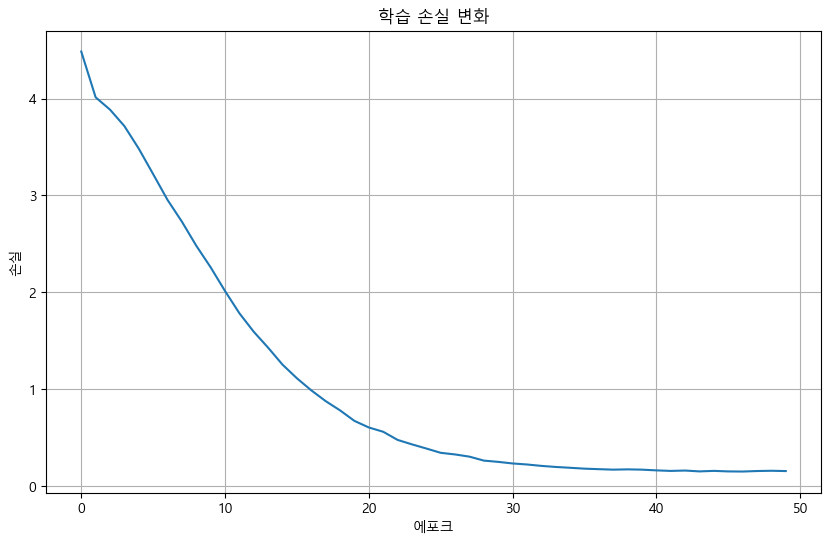

In [7]:
if __name__ == "__main__":
    # 로미오와 줄리엣 텍스트 (파일에서 로드됨)
    romeo_juliet_text = """
    [제목] 로미오와 줄리에트
    셰익스피어
    로미오와 줄리에트
    김재남 옮김

    [프롤로그]
    다같이 세도 있는 두 집안이 아름다운 베로나를 무대로 오랫동안 쌓인 원한에서 또 싸움을 일으키니, 시민의 피가 시민의 손을 더럽힌다.
    숙명적인 이 두 원수의 집안에서 불운한 한 쌍의 애인이 태어난다. 이들 불행하고 불우한 사랑의 파멸은 죽음으로써 두 집안의 갈등을 매장한다.

    [1막 1장]
    로미오: 마음이 여기 있는데, 어떻게 이대로 지나갈 수 있단 말인가?
    줄리에트: 아, 로미오, 로미오님! 왜 이름이 로미오인가요? 아버지를 잊으시고 그 이름을 버리세요.
    로미오: 그 말대로 당신을 갖겠소. 나를 사랑한다고만 말해 주면, 새로 세례를 받은 것과 같이 이제부터 로미오란 이름을 영영 버리겠소.
    """

    #with open("data/romeo.txt", "r", encoding="utf-8") as f:
    #    romeo_juliet_text = f.read()

    # 언어 모델 초기화 및 학습
    lm = RomeoJulietLM()

    print("모델 학습 시작...")
    losses = lm.train(romeo_juliet_text, epochs=50, batch_size=2, seq_length=64)

    print("\n학습 완료! 텍스트 생성 테스트:")

    # 다양한 프롬프트로 텍스트 생성
    prompts = ["로미오", "줄리에트", "사랑", "베로나"]

    for prompt in prompts:
        print(f"\n프롬프트: '{prompt}'")
        generated = lm.generate_text(prompt, max_length=100, temperature=0.7)
        print(f"생성된 텍스트: {generated}")

    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title("학습 손실 변화")
    plt.xlabel("에포크")
    plt.ylabel("손실")
    plt.grid(True)
    plt.show()